# Statistical Functionality

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
from scipy import stats

theme, cs = rp.mpl_setup(True)

p-values are formatted in a specific way in the literature. There's not any standard library approach that replicates it, so here goes:

In [280]:
@np.vectorize()
def format_pval(pval, places=3):
    """Formats a single p-value or a list of p-values.
    By default, formats as 'p = 0.012', with values that
    would round to 'p = 0.000' instead being represented
    as 'p < 0.001'. Places controls how many decimals to use."""
    if pval < 10 ** (-places):
        return 'p < 0.{}1'.format('0' * (int(places) - 1))
    else:
        pstr = format(pval, f'.0{places}f')
        return f'p = {pstr}'
        
format_pval(pd.Series(np.random.rand(10), name='x'))

array(['p = 0.455', 'p = 0.650', 'p = 0.209', 'p = 0.378', 'p = 0.845',
       'p = 0.493', 'p = 0.179', 'p = 0.303', 'p = 0.218', 'p = 0.604'],
      dtype='<U9')

There are a couple useful descriptive statistics that aren't in numpy for some reason.

In [281]:
def iqr(x, **kwargs):
    return np.quantile(x, 0.75, **kwargs) - np.quantile(x, 0.25, **kwargs)

def expit(x):
    """Returns the logistic function 1/(1 + exp(-x))."""
    return 1 / (1 + np.exp(-x))

def midrange(x, **kwargs):
    """Returns the mean of the min and max."""
    return 0.5 * (np.min(x, **kwargs) + np.max(x, **kwargs))


There are many measures of the center of a dataset: the mean and median are the most common. What if we don't want to first figure out if our dataset has outliers, and we just want it to do the right thing?

We can generalize the mean and median as such. We define the $p$-center of a dataset $x_1, x_2, \dots, x_n$ to be the value $u$ (if a unique value exists) that minimizes

$$ \sum_{i=1}^n |x_i - u|^p $$

Then the median is the 1-center and the mean is the 2-center. As $p \to \infty$, this becomes the *midrange*: $\frac{\max x + \min x}{2}$. As $p \to 0$, this becomes the mode, but this is quite unstable in practice. We're mostly interested in $p \in [1, 2]$, as a continuous parameter that controls robustness.

We can zoom out and get a more powerful set of tools by considering this approach as maximum likelihood estimation (MLE) of different probability distributions.

The MLE for a Gaussian distribution is exactly the mean and sample variance of a dataset: the Gaussian's log-likelihood is proportional to the squared distance to the mean, so this follows directly from the above. The MLE for a Laplace distribution is the median for the same reason.

In general, we can define a family of generalized location-scale distributions parameterized by $p$, a location $u$, and a scale $s$:

$$ P(x; u, s, p) \propto \exp \left(-\frac{1}{p} \left|\frac{x - u}{s}\right|^p \right) $$

This is chosen such that $p = 1$ gives us the Laplace and $p = 2$ gives us the Gaussian.

We need a closed-form normalizing constant if this is to be tractable, however:

In [282]:
from sympy import *

x, u = symbols('x u', real=True)
s, p = symbols('s p', real=True, positive=True)

def show_expr(expr):
    ans = expr.doit().simplify()
    display(Eq(expr, ans))
    return ans

unscaled_pdf = exp(-(1 / p) * abs((x - u) / s) ** p)
Z_raw = Integral(unscaled_pdf, (x, -oo, oo))

Z = show_expr(Z_raw)

Eq(Integral(exp(-(Abs(u - x)/s)**p/p), (x, -oo, oo)), 2*p**(1/p)*s*gamma(1 + 1/p))

I'm honestly surprised there is a such a clean closed form for this. This lets us define the proper PDF:

In [283]:
pdf = unscaled_pdf / Z

class P(Function):
    @staticmethod
    def inner(_x):
        return pdf.subs({x: _x})
    
    @classmethod
    def eval(cls, _x):
        if isinstance(_x, Number):
            return cls.inner(_x)
        else:
            return None
        
    def doit(self, deep=True, **hints):
        _x = self.args
        # Recursively call doit() on the args whenever deep=True.
        # Be sure to pass deep=True and **hints through here.
        if deep:
            _x = x.doit(deep=deep, **hints)
        
        return self.inner(_x)
    
show_expr(P(x));

Eq(P(x), exp(-Abs(u - x)**p/(p*s**p))/(2*p**(1/p)*s*gamma(1 + 1/p)))

We can show that this distribution has $E[X] = u$ and $\sqrt[p]{E[|X - u|^p]} = s$. This means that both $u$ and $s$ are actually the location and scale parameters we want: for the Gaussian, they're the mean and standard deviation, and for the Laplace they're the median and mean absolute deviation. 

In [284]:
show_expr(integrate(x * P(x), (x, -oo, oo)));
show_expr(Integral(abs(x - u) ** p * P(x), (x, -oo, oo)) ** (1 / p));

Eq(Integral(x*P(x), (x, -oo, oo)), u)

Eq(Integral(Abs(u - x)**p*P(x), (x, -oo, oo))**(1/p), s)

Using a probabilistic framework makes picking $p$ simple: we find the $p$ that maximizes the likelihood of our data. This gives us $u$ and $s$, an intelligent center and dispersion statistic for our data.

To make this easier to work with computationally, I should probably implement the ziggurat algorithm for random sampling in the future. Until then:

In [300]:
from scipy.special import gamma
class minkowski_gen(stats.rv_continuous):
    """Minkowski family of distributions with loc, scale, and p.
    p = 1 gives Laplace.
    p = 2 gives Gaussian."""
    def _pdf(self, x, p):
        return np.exp(-1 / p * abs(x) ** p) / (2 * p ** (1 / p) * gamma(1 + 1 / p))
    
    def _fitstart(self, data):
        return (2, np.mean(data), np.std(data))

minkowski = minkowski_gen(name='minkowski')

In [310]:
rvs = stats.norm.rvs(size=10000)
minkowski.fit(rvs)

(2.0176519408807785, 0.018067184902006768, 1.00296367516868)

In [286]:
from ipywidgets import interact

xx = np.linspace(-6, 6, 1000)

@interact(p=(0.5, 3, 0.1))
def plot_minkowski(p=1.5):
    plt.plot(xx, minkowski(p=p).pdf(xx))
    plt.ylim(0, 0.5)

interactive(children=(FloatSlider(value=1.5, description='p', max=3.0, min=0.5), Output()), _dom_classes=('wid…

In [287]:
y = symbols('y', real=True)
integrate(pdf, (x, -oo, y))

Integral(exp(-Abs(u - x)**p/(p*s**p)), (x, -oo, y))/(2*p**(1/p)*s*gamma(1 + 1/p))

In [288]:
# MLE estimates: u doesn't have a closed-form solution, s is the expected spread value
# should probably do Bessel correction?

# diff(log(P(x)).doit().expand(), u).expand().simplify()
# diff(log(P(x)).doit().expand(), s).expand().simplify()

In [289]:
df = sns.load_dataset('diamonds')
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


Text(0.5, 1.0, 'p = 1.137\nμ = 61.810\nσ = 1.070')

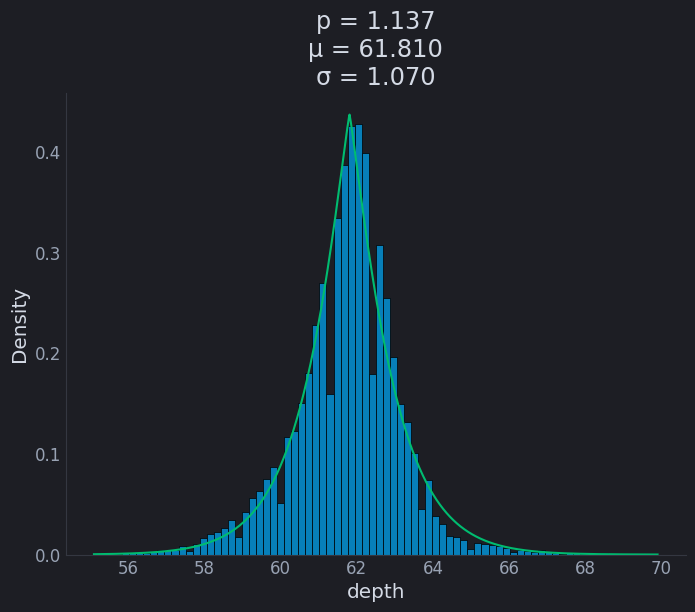

In [339]:
# xx = df.eval('y')[67::1000]
# xx = df.eval('log(depth)')
xx = df.query('depth > 55 and depth < 70').eval('depth')
sns.histplot(xx, stat='density', bins=80)
params = minkowski.fit(xx)
mink = minkowski(*params)

xvals = np.linspace(min(xx), max(xx), 1000)
plt.plot(xvals, mink.pdf(xvals), c=cs[1])
plt.title('\n'.join(f'{name} = {stat:.03f}' for name, stat in zip('pμσ', params)))

In [312]:
p, u, s = minkowski.fit(xx.values)


(1.087532069712075, 4.124009220458542, 0.01718834709625578)